In [1]:
import os
import re
import PIL
import sys
import sls
import cv2
import json
import time
import glob
import math
import timm
import copy
import torch
import pickle
import geffnet
import logging
import fnmatch
import argparse
import itertools
import torchvision
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import torch.nn as nn
from PIL import Image
from glob import glob
from pathlib import Path
from copy import deepcopy
from sklearn import metrics
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim import lr_scheduler
import torch.utils.model_zoo as model_zoo
%config InlineBackend.figure_format = 'retina'
from efficientnet_pytorch import EfficientNet
from collections import OrderedDict, defaultdict
from torchvision import transforms, models, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from randaugment import RandAugment, ImageNetPolicy, Cutout
from sklearn.metrics import confusion_matrix,accuracy_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [2]:
data_dir = '/home/linh/Downloads/DeepWeeds'

valid_dir = data_dir + "/data" #'/NCT-CRC-HE-100K-NONORM' 

# Define your transforms for the training and testing sets
data_transforms = {  
    'data':  transforms.Compose([
             transforms.RandomRotation(30),
             transforms.Resize(256),
             transforms.RandomResizedCrop(224),        
             transforms.CenterCrop(224),
             transforms.RandomHorizontalFlip(),
             RandAugment(),
             ImageNetPolicy(),
             Cutout(size=16), 
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
                                ])

                    }

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['data']}

# Using the image datasets and the trainforms, define the data_loader
# batch_size = 64 for B0, B1, B2, B3; batch_size = 32 for B4; batch_size = 16 for B5
# batch_size = 8 for B6, B7
batch_size = 32
data_loader = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=4)
              for x in ['data']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['data']}

class_names = image_datasets['data'].classes

print(dataset_sizes)
print(device)

"""# Label mapping
with open('/home/linh/Downloads/CRC/cat_to_name_7K.json', 'r') as f:
    cat_to_name = json.load(f)"""

'''f = open('/home/linh/Downloads/Derma/classes.txt','r')
cat_to_name = f.read()
print(cat_to_name)
f.close()    
'''
### we get the class_to_index in the data_Set but what we really need is the cat_to_names  so we will create
_ = image_datasets['data'].class_to_idx
cat_to_name = {_[i]: i for i in list(_.keys())}

    
# Run this to test the data loader
images, labels = next(iter(data_loader['data']))
images.size()

{'data': 17509}
cuda:0


torch.Size([32, 3, 224, 224])

checkpoint loaded
prediction time for complete in 51327 milisecond
              precision    recall  f1-score   support

           0   0.406756  0.781333  0.534997      1125
           1   0.568612  0.677632  0.618353      1064
           2   0.860476  0.627828  0.725968      9106
           3   0.807843  0.599418  0.688196      1031
           4   0.300418  0.773973  0.432832      1022
           5   0.551774  0.717514  0.623823      1062
           6   0.668211  0.714569  0.690613      1009
           7   0.776298  0.542831  0.638904      1074
           8   0.718259  0.584646  0.644601      1016

    accuracy                       0.650294     17509
   macro avg   0.628739  0.668860  0.622032     17509
weighted avg   0.734577  0.650294  0.669529     17509



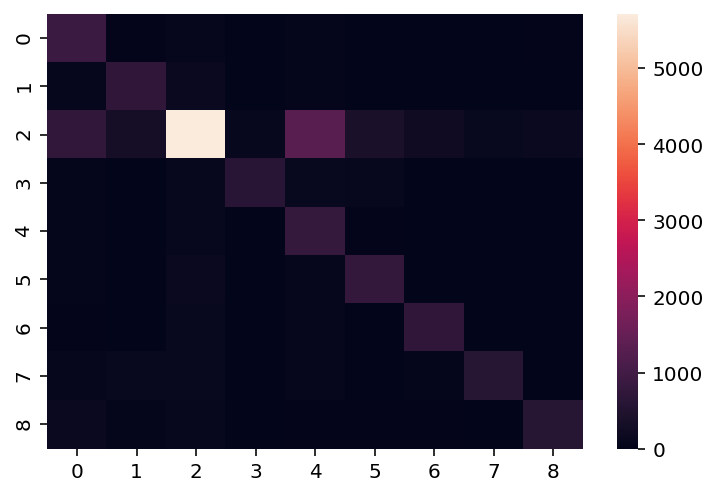

In [3]:
#model = EfficientNet.from_pretrained('efficientnet-b3')
#model = timm.create_model('tf_efficientnet_b6', pretrained = True)
#from efficientnet_pytorch import EfficientNet
#model = EfficientNet.from_pretrained('efficientnet-b6')
#model = timm.create_model('tf_efficientnet_b4_ap', pretrained=True)
#model = timm.create_model('tf_efficientnet_b4_ns', pretrained=True)
model = geffnet.create_model('tf_efficientnet_lite4', pretrained=True)

# Create classifier
for param in model.parameters():
    param.requires_grad = True
n_classes = 9
model.classifier = nn.Linear(model.classifier.in_features, n_classes)
criterion = nn.CrossEntropyLoss()
#optimizer = Nadam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), 
                      lr=0.001,momentum=0.9,
                      nesterov=True,
                      weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model.to(device)

CHECK_POINT_PATH = '/home/linh/Downloads/DeepWeeds/weights/EfficientNet_Lite4_SGD.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/DeepWeeds/weights/EfficientNet_B4_NS_SGD.pth'
#CHECK_POINT_PATH = '/home/linh/Downloads/DeepWeeds/weights/EfficientNet_B4_AP_SGD.pth'
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

def load_model(path):                                
    model.load_state_dict(checkpoint['model_state_dict'])
    best_model_wts = copy.deepcopy(model.state_dict())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['best_val_loss']
    best_acc = checkpoint['best_val_accuracy']
load_model(CHECK_POINT_PATH)  
#calculate time for prediction
#set start time to predict
since = round(time.monotonic() * 1000)
model.eval()
y_test = []
y_pred = []

for i, (images, labels) in enumerate(data_loader['data']):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())

'''for images, labels in data_loader['test_0']:
    images = Variable(images.cuda())
    labels = Variable(labels.cuda())
    outputs = model(images)
    _, predictions = outputs.max(1)
    
    y_test.append(labels.data.cpu().numpy())
    y_pred.append(predictions.data.cpu().numpy())'''

#set the end time to predict
time_elapsed = round(time.monotonic() * 1000) - since   
print('prediction time for complete in {:.0f} milisecond'.format(time_elapsed))
#print('Prediction time to complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#concat predicted results to be dataframe
y_test = np.concatenate(y_test)
y_pred = np.concatenate(y_pred)

#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/DeepWeeds/results/EfficientNet_Lite_0_SGD_Whole_dataset.csv',index=False)
#pd.DataFrame({'true_label':y_test,'predicted_label':y_pred}).to_csv('/home/linh/Downloads/DeepWeeds/results/EfficientNet_Lite_4_SGD_test_5.csv',index=False)

sns.heatmap(confusion_matrix(y_test, y_pred))
# set accuracy score to control processes
accuracy_score(y_test, y_pred)

# Generate a classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=6)
print(report)